In [1]:
pca_components = 50
kmeans = True 

In [2]:
def data_split(dataset):
    """
    Args:
        chid: which assay to use:
        external_file:
    Returns:
        clfs: Dictionary of fitted classifiers
        aucs: Dictionary of AUCs
        balance: Two numbers showing the number of actives in split 1 / split 2
        df1: data in split 1
        df2: data in split 2
    """
    # read data and calculate ecfp fingerprints
    assay_file = f'datasets/{dataset}.csv'
    print(f'Reading data from: {assay_file}')
    df = pd.read_csv(assay_file)
          
    df['ecfp'] = ecfp4(df.smiles)
    df_train, df_test = train_test_split(df, test_size=0.25, stratify=df['label'], random_state=0)
    X1 = np.array(list(df_train['ecfp']))
    X2 = np.array(list(df_test['ecfp']))
    y1 = np.array(list(df_train['label']))
    y2 = np.array(list(df_test['label']))
      
    
    # train classifiers and store them in dictionary
    
    clf = RandomForestClassifier( 
        n_estimators=100, n_jobs=1, random_state=0)
    clf.fit(X1, y1)
    return clf.predict_proba(X2[np.where(y2==1)[0], :])[:, 1], list(df_test.smiles), list(df_test.label), clf

# Analysis

In [156]:
import os
import numpy as np
import json
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.decomposition import PCA
from utils import data_split, ClusterFps, ecfp4, find_cluster, max_tanimoto_similarity, indexes_identical_fps, average_tanimoto_similarity, tanimoto_similarities, calculateScore, Descriptors, quantitative_analysis

import matplotlib.pyplot as plt
import math
import scipy
import pandas as pd
import seaborn as sns 
import matplotlib
from sklearn.cluster import KMeans

font = {'family' : 'normal',
        'size'   : 35}

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': 35,
    'text.usetex': True,
    'pgf.rcfonts': False,
})


matplotlib.rcParams['axes.unicode_minus'] = False
sns.set()
%matplotlib inline


pca_components = 50
kmeans = True 

In [157]:
# Load classifiers and test set for downstream analysis
# Prend en entrée un csv du dataset jak2 smiles, value 
# Modifier data_split dans utils.py pour avoir le bon path du dataset line 355 de utils.py

scores_test, smiles_test, activities_test, clf = data_split(assay_name)

Reading data from: datasets/CHEMBL3888429_cleaned.csv


In [158]:
# Get actives and inactives from test set 
actives = []
inactives = []
smiles_actives = []
smiles_inactives = []

for i, s in enumerate(smiles_test):
    mol = Chem.MolFromSmiles(s)
    if float(activities_test[i])==1:
        actives.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
        smiles_actives.append(s)
    else:
        inactives.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
        smiles_inactives.append(s)


In [159]:
runs = [] # Combined, QSAR 
smiles_list = [] # [[SMILES 1, SMILES 2], [SMILES QSAR 1, SMILES QSAR 2]]
scores_list = [] # [[scores 1, scores 2], [scores QSAR 1, scores QSAR 2]]

['ecfp4_filters_validity_ecfp4', 'ecfp4_range_physchem_maxsim_ecfp4', 'ecfp4_range_qed', 'ecfp4_maxsim_ecfp6', 'ecfp4_range_ecfp4_counts', 'ecfp4_range_physchem_range_ecfp6', 'ecfp4_smiles_validity_ecfp4', 'ecfp4_range_physchem_maxsim_ecfp6', 'ecfp4_range_physchem_range_ecfp4', 'ecfp4_range_physchem_range_ecfp4_counts', 'ecfp4_range_physchem', 'ecfp4_range_physchem_maxsim_ap', 'ecfp4_range_physchem_range_ap', 'ecfp4_maxsim_ecfp4', 'ecfp4_maxsim_ap', 'ecfp4_range_ecfp4']


In [160]:
# Cluster the test set for downstream analysis 
X = np.array(actives + inactives)
clustering = KMeans(n_clusters=5, random_state=0).fit(X)

kmeans_clusters = clustering.labels_
training_set_clusters = ClusterFps(actives + inactives, cutoff=0.5)
centroids = [cluster[0] for cluster in training_set_clusters]
fp_list = actives + inactives
centroids_fp = [fp_list[centroid] for centroid in centroids]

In [161]:
# Get all fingerprints to run all analysis faster 
fps_active_as_array = []
fps_active_as_bitv = []
fps_inactive_as_array = []
fps_inactive_as_bitv = []
fps_generated_as_array = []
fps_generated_as_bitv = []

for s in smiles_actives:
    mol = Chem.MolFromSmiles(s)
    fps_active_as_array.append(np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2)))
    fps_active_as_bitv.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
    
for s in smiles_inactives:
    mol = Chem.MolFromSmiles(s)
    fps_inactive_as_array.append(np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2)))
    fps_inactive_as_bitv.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
    
for i, run in enumerate(runs):
    smiles_generated = smiles_list[i]
    curr_fps_generated_as_array = []
    curr_fps_generated_as_bv = []
    for s in smiles_generated:
        mol = Chem.MolFromSmiles(s)
        curr_fps_generated_as_array.append(np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2)))
        curr_fps_generated_as_bv.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
    fps_generated_as_array.append(curr_fps_generated_as_array)
    fps_generated_as_bitv.append(curr_fps_generated_as_bv)
    

In [162]:
# Fits PCA on test set 
pca = PCA(n_components=2).fit(np.concatenate((fps_inactive_as_array,fps_inactive_as_array)))
pca_active = pca.transform(fps_active_as_array)
pca_inactive = pca.transform(fps_inactive_as_array)

pca_generated = []

for i, run in enumerate(runs):
    curr_fps_generated = fps_generated_as_array[i]
    pca_generated.append(pca.transform(curr_fps_generated))

In [163]:
xmin_ymin = np.amin(np.vstack([np.amin(p, axis=0) for p in pca_generated]), axis=0).tolist()

In [164]:
xmax_ymax = np.amax(np.vstack([np.amax(p, axis=0) for p in pca_generated]), axis=0).tolist()

In [165]:
x_lims = [xmin_ymin[0]] + [xmax_ymax[0]]
y_lims = [xmin_ymin[1]] + [xmax_ymax[1]]

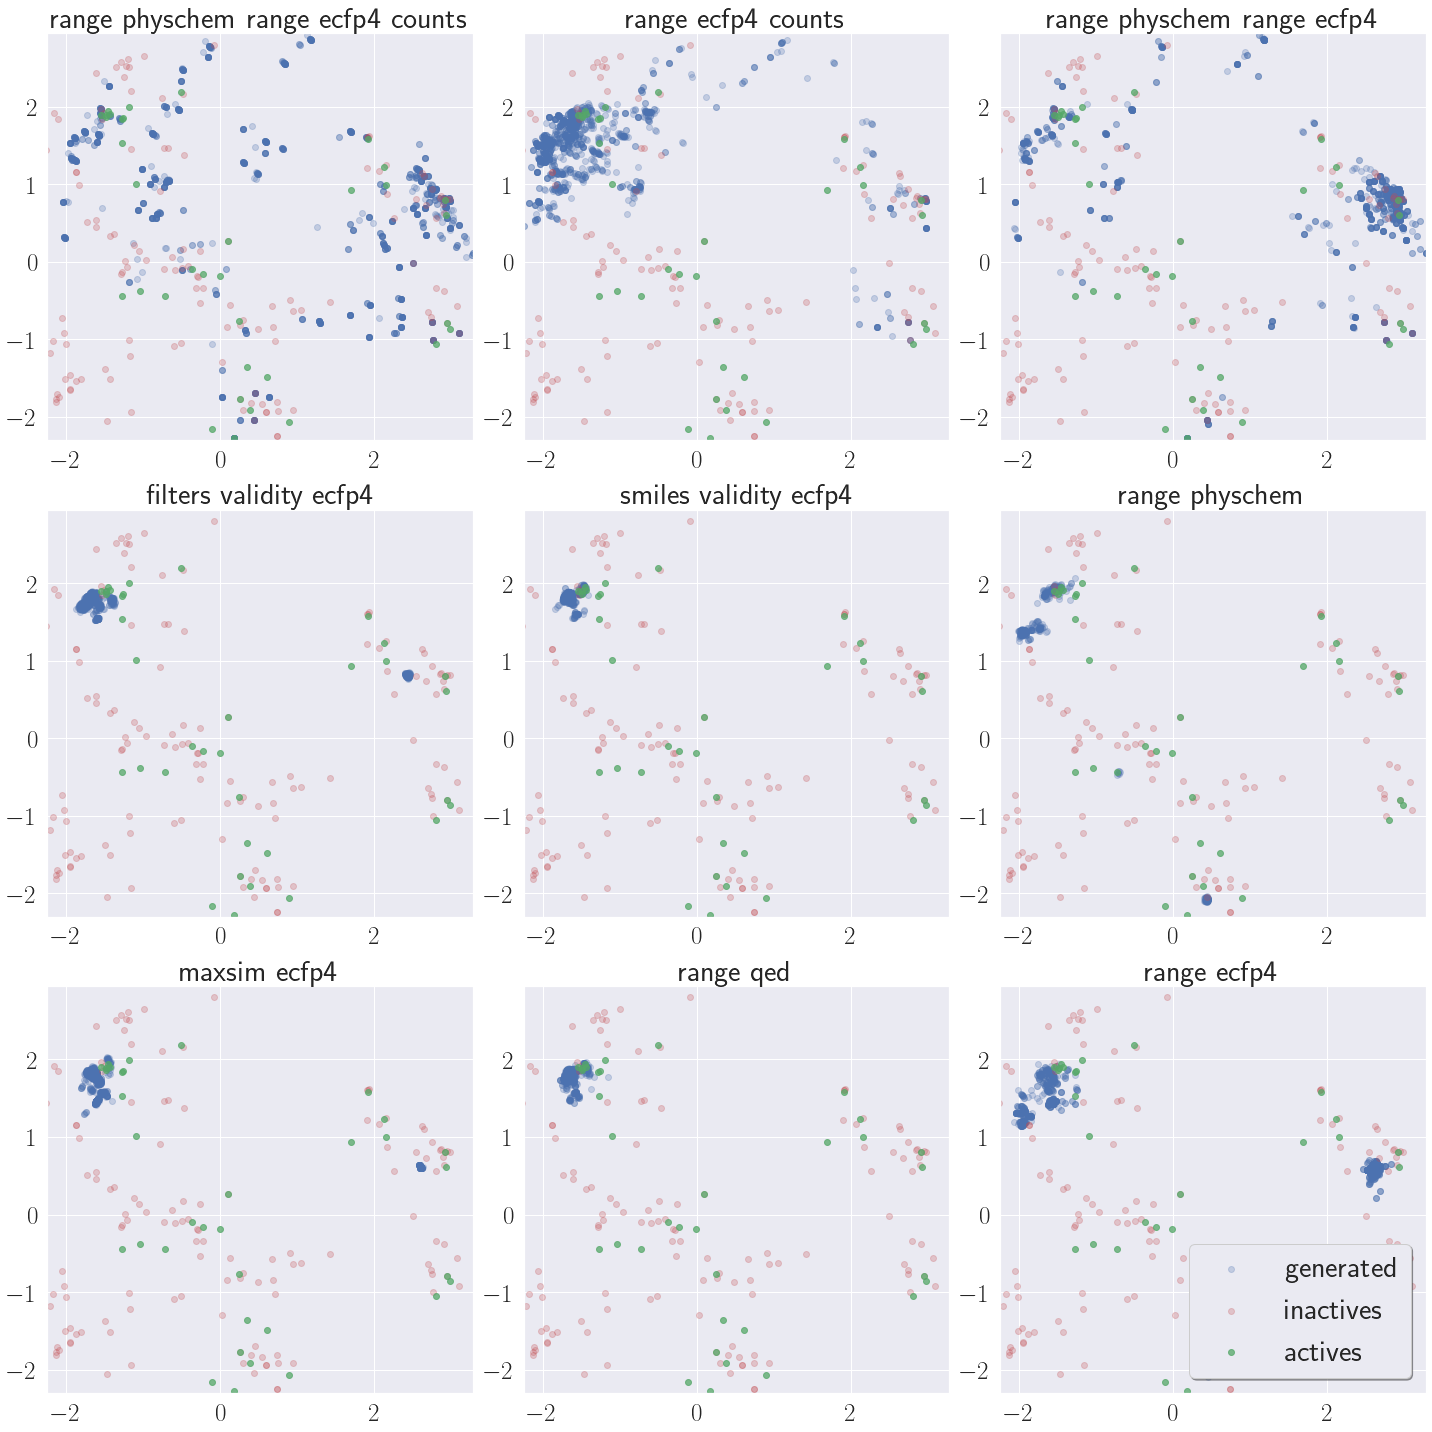

In [166]:
# Displays PCA for selected runs 
runs_to_display = runs

fig, axs = plt.subplots(figsize = (20, 20), nrows=max(1, math.ceil(len(runs_to_display)/3)) , ncols=3)
fig.tight_layout(pad=1.5)

for i, run in enumerate(runs_to_display):
    index = runs.index(run)
    pca_gen = pca_generated[index]
    ax = axs.flatten()[i]
    ax.set_title(run.replace('_', ' '), fontsize=30)
    ax.set_ylim(y_lims)
    ax.set_xlim(x_lims)
    ax.scatter(pca_gen[:, 0], pca_gen[:, 1], c='b', label = 'generated', alpha=0.25)
    ax.scatter(pca_inactive[:, 0], pca_inactive[:, 1], c='r', label = 'inactives', alpha=0.25)
    ax.scatter(pca_active[:, 0], pca_active[:, 1], c='g', label = 'actives', alpha=0.75)
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.tick_params(axis='both', which='minor', labelsize=25)
    if i==len(runs_to_display)-1: 
        ax.legend(loc='lower right',
              ncol=1, fancybox=True, shadow=True, fontsize=30)
    
plt.tight_layout()
plt.savefig('images/JAK2/PCA.pdf', dpi=300)   

In [167]:
# Computes entropy for the different runs 
pca_generated = []
entropies = []
clusters = []
    
pca = PCA(n_components=2).fit(np.concatenate((fps_active_as_array,fps_inactive_as_array)))
pca_active = pca.transform(fps_active_as_array)
pca_inactive = pca.transform(fps_inactive_as_array)
predicted_actives = np.where(clf.predict_proba(ecfp4(smiles_actives))[:, 1]>0.5)[0]

for i, run in enumerate(runs):
    curr_fps_generated = fps_generated_as_array[i]
    curr_fps_generated_bitv = fps_generated_as_bitv[i]    
    pca_generated.append(pca.transform(curr_fps_generated))
    if kmeans:
        curr_clusters = clustering.predict(curr_fps_generated)  
    else:
        curr_clusters = [find_cluster(fp, centroids_fp) for fp in curr_fps_generated_bitv]
    probs = []
    for i in range(len(np.unique(centroids))):
        probs.append(len(np.where(np.array(curr_clusters)==i)[0])/len(curr_clusters))
    entropy = scipy.stats.entropy(probs)/ np.log(len(curr_clusters))
    clusters.append(curr_clusters)
    entropies.append(entropy)

In [168]:
xmin_ymin = np.amin(np.vstack([np.amin(p, axis=0) for p in pca_generated]), axis=0).tolist()
xmax_ymax = np.amax(np.vstack([np.amax(p, axis=0) for p in pca_generated]), axis=0).tolist()
x_lims = [xmin_ymin[0]] + [xmax_ymax[0]]
y_lims = [xmin_ymin[1]] + [xmax_ymax[1]]

Text(0.5, 1.05, 'PCA projections of generated molecules in the training set actives/inactives space\nHighlighting predicted actives')

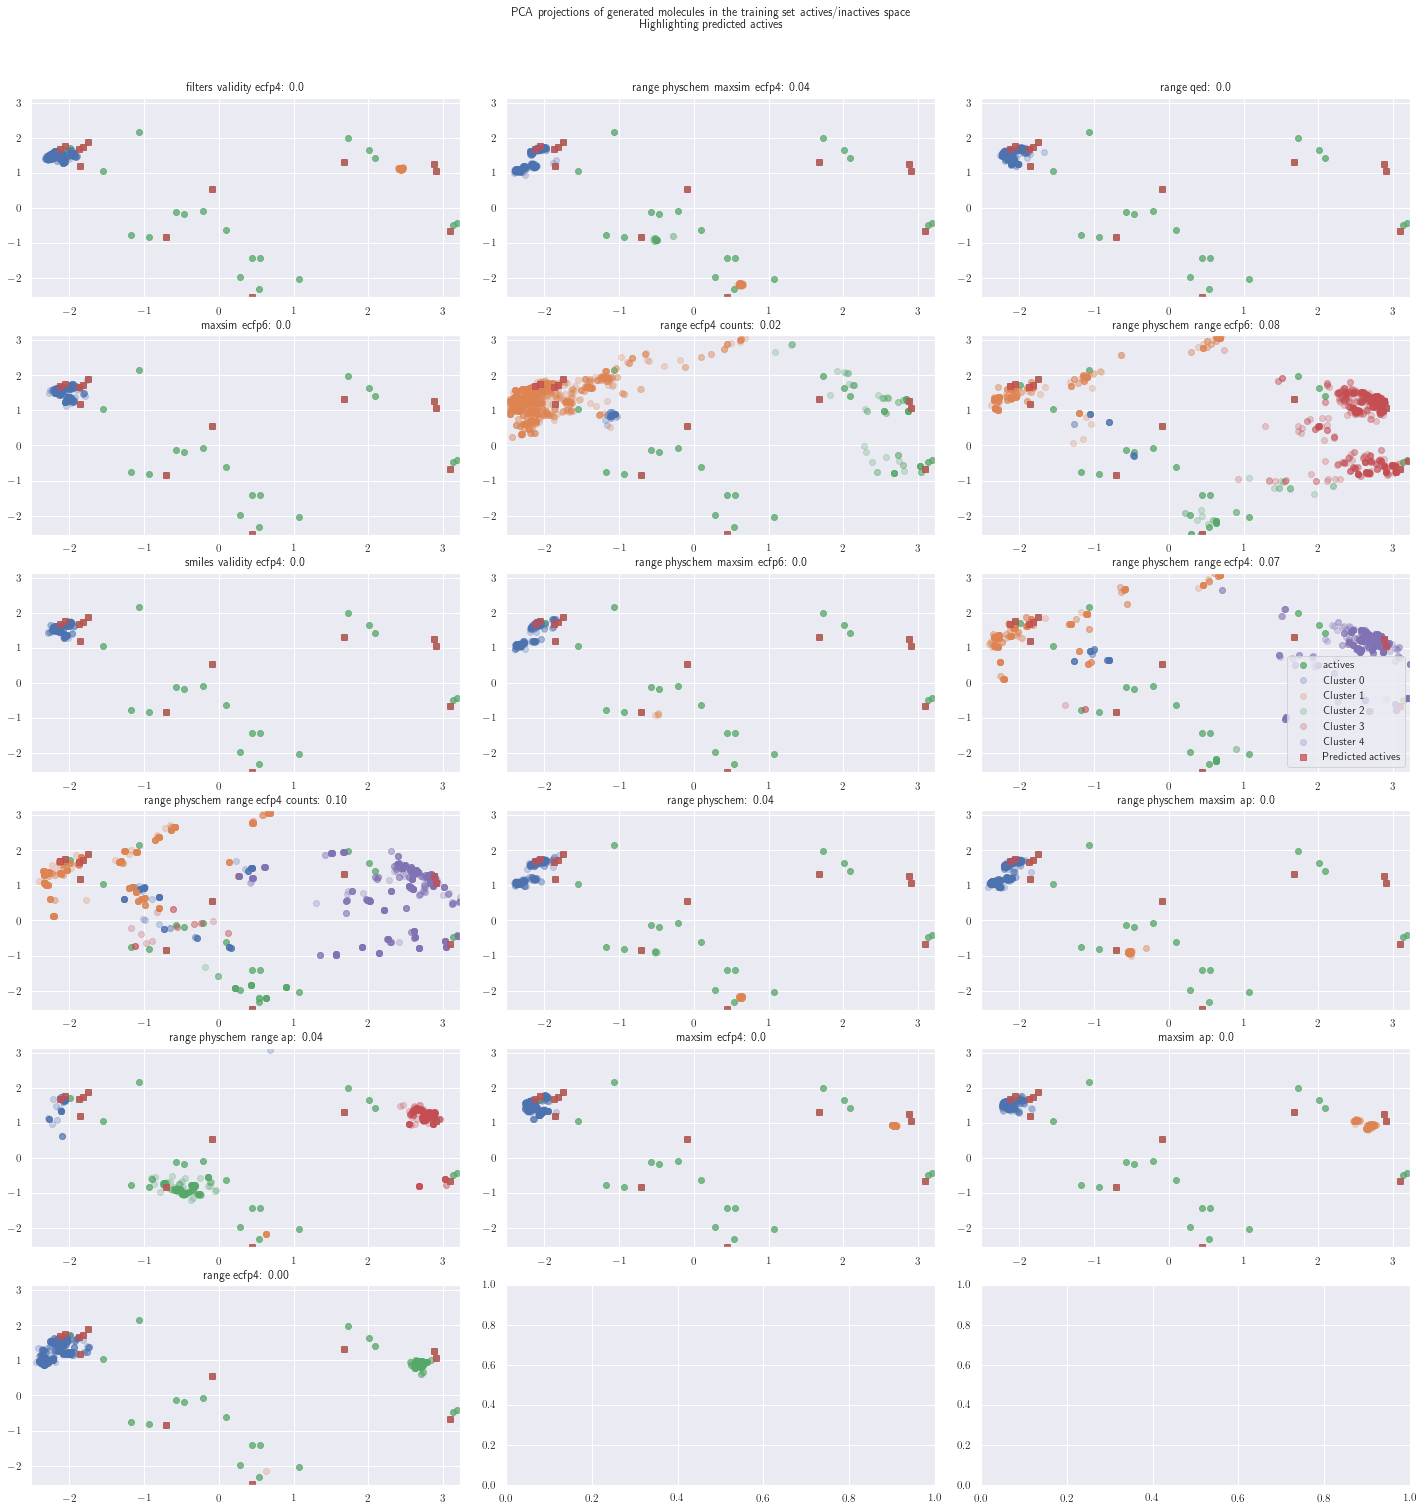

In [169]:
# PCA projection of generated sets with color by clusters
fig, axs = plt.subplots(figsize = (20, 20), nrows=max(1, math.ceil(len(runs)/3)) , ncols=3)
fig.tight_layout(pad=1.5)
no_legend = 0

for i, run in enumerate(runs):
    curr_clusters = clusters[i]
    entropy = entropies[i]
    pca_gen = pca_generated[i]
    ax = axs.flatten()[i]
    ax.set_title(run.replace('_', ' ') + ': ' + str(entropy)[:4])
    ax.set_ylim(y_lims)
    ax.set_xlim(x_lims)
    ax.scatter(pca_active[:, 0], pca_active[:, 1], c='g', label = 'actives', alpha=0.75)    
    for c in np.unique(curr_clusters):
        ax.scatter(pca_gen[:, 0][np.where(curr_clusters==c)], pca_gen[:, 1][np.where(curr_clusters==c)], label= 'Cluster ' + str(c), alpha=0.25)    

    ax.scatter(pca_active[predicted_actives, 0], pca_active[predicted_actives, 1], c='r', label = 'Predicted actives', alpha=0.75, marker='s')
    #ax.scatter(pca_inactive[:, 0], pca_inactive[:, 1], c='r', label = 'inactives', alpha=0.25)
    if len(np.unique(curr_clusters)) == np.amax([len(set(c)) for c in clusters]) and  no_legend == 0 :
        ax.legend(loc=4)
        no_legend = 1
fig.suptitle('PCA projections of generated molecules in the training set actives/inactives space\nHighlighting predicted actives',fontweight ="bold", y=1.05)    

In [175]:
# Computes QED and SAS for the test set 
qed_dataset = []
sas_dataset = []
for s in smiles_actives + smiles_inactives:
    mol = Chem.MolFromSmiles(s)
    qed_dataset.append(Descriptors.qed(mol))
    sas_dataset.append(calculateScore(mol))

In [176]:
# Computes QED and SAS for generated sets 
QED = []
SAS = []

SAS_for_results = []
QED_for_results = []
ad = []
for i, run in enumerate(runs):
    avg_sims = []
    max_sim = []
    smiles_generated = smiles_list[i]
    qed_generated = []
    sas_generated = []
    for s in smiles_generated:
        mol = Chem.MolFromSmiles(s)
        qed_generated.append(Descriptors.qed(mol))
        sas_generated.append(calculateScore(mol))

    
        
        QED.append(Descriptors.qed(mol))
        SAS.append(calculateScore(mol))
        ad.append(run)
    SAS_for_results.append(sas_generated)
    QED_for_results.append(qed_generated)

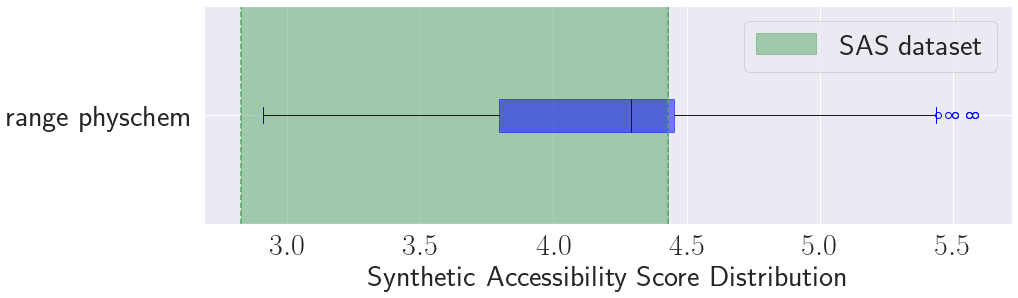

In [255]:
# Plots SAS distributions 
matplotlib.rcParams.update({'font.size': 35})

plt.figure(figsize= (15, 5))

c = 'blue'
box = plt.boxplot(SAS_for_results, labels = np.array([x.replace('_', ' ') for x in runs]), vert=False, patch_artist=True,
            boxprops=dict(facecolor=c, color=c, alpha=0.5),
            capprops=dict(color=c),
            whiskerprops=dict(color='k'),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color='k'),)



plt.axvline(np.percentile(sas_dataset, 100), ls='--', c='g')
plt.axvline(np.percentile(sas_dataset, 0), ls='--', c='g')
xmin, xmax, ymin, ymax = plt.axis()
plt.fill_between([np.percentile(sas_dataset, 0), np.percentile(sas_dataset, 100)], ymin, ymax, color='g', alpha=0.5, label = 'SAS dataset')
plt.xlabel("Synthetic Accessibility Score Distribution", fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=30)

plt.tight_layout()
#plt.savefig('images/JAK2/SAS_distribution.pdf', dpi=300)

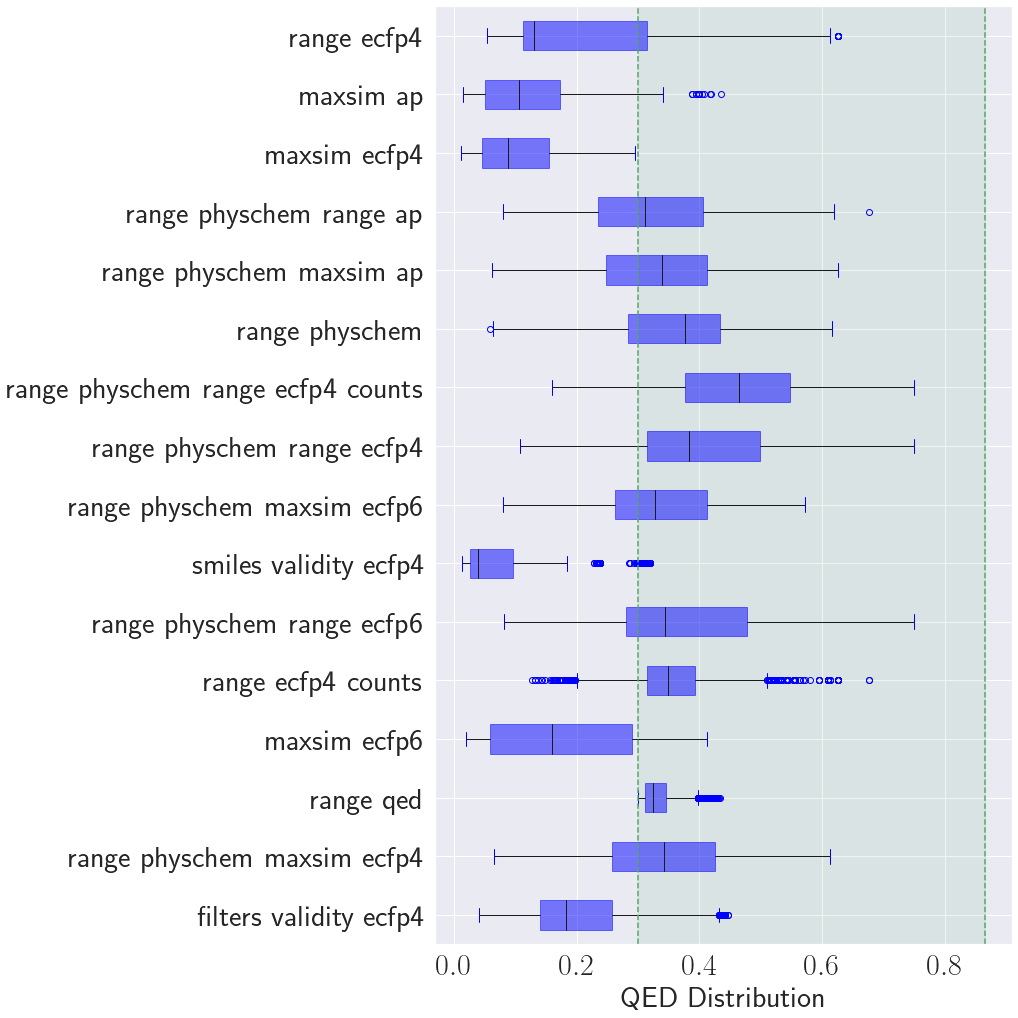

In [178]:
# Plots QED distributions 
plt.figure(figsize= (15, 15))
c = 'blue'
box = plt.boxplot(QED_for_results, labels = [x.replace('_', ' ') for x in runs], vert=False, patch_artist=True,
            boxprops=dict(facecolor=c, color=c, alpha=0.5),
            capprops=dict(color=c),
            whiskerprops=dict(color='k'),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color='k'),)

plt.axvline(np.percentile(qed_dataset, 100), ls='--', label='Dataset extreme QED values', c='g')
plt.axvline(np.percentile(qed_dataset, 0), ls='--', c='g')
xmin, xmax, ymin, ymax = plt.axis()
plt.fill_between([np.percentile(qed_dataset, 0), np.percentile(qed_dataset, 100)], ymin, ymax, color='g', alpha=0.1, label = 'Valid QED')
plt.xlabel("QED Distribution", fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)


plt.tight_layout()
plt.savefig('images/JAK2/QED_distribution.pdf', dpi=300)

# Comparing different AD's outputs

In [179]:
from utils import qualitative_analysis, return_distribution_cycle_size, return_distribution_mw, return_distribution_halogen, return_distribution_heteroatoms, return_distribution_radicals, return_distribution_sulphur, qualitative_analysis

In [182]:
# Computes average similarities between runs from the "best methods"
average_similarities = []
max_similarities = []
common_molecules = {}
for i, run in enumerate(runs):
    avg_sims = []
    max_sim = []
    smiles_generated = smiles_list[i]
    fps_generated = fps_generated_as_bitv[i]
    for j, comparison_run in enumerate(best_methods):
        smiles_generated = smiles_list[j]
        fps_other = fps_generated_as_bitv[j]
        if j<i:
            indexes, indexes_other = indexes_identical_fps(fps_generated, fps_other)
            common_molecules[run + '_vs_' + comparison_run] = [indexes, indexes_other] 
        avg_sims.append(average_tanimoto_similarity(fps_generated, fps_other))
        max_sim.append(max_tanimoto_similarity(fps_generated, fps_other))
    average_similarities.append(avg_sims)
    max_similarities.append(max_sim)

/opt/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


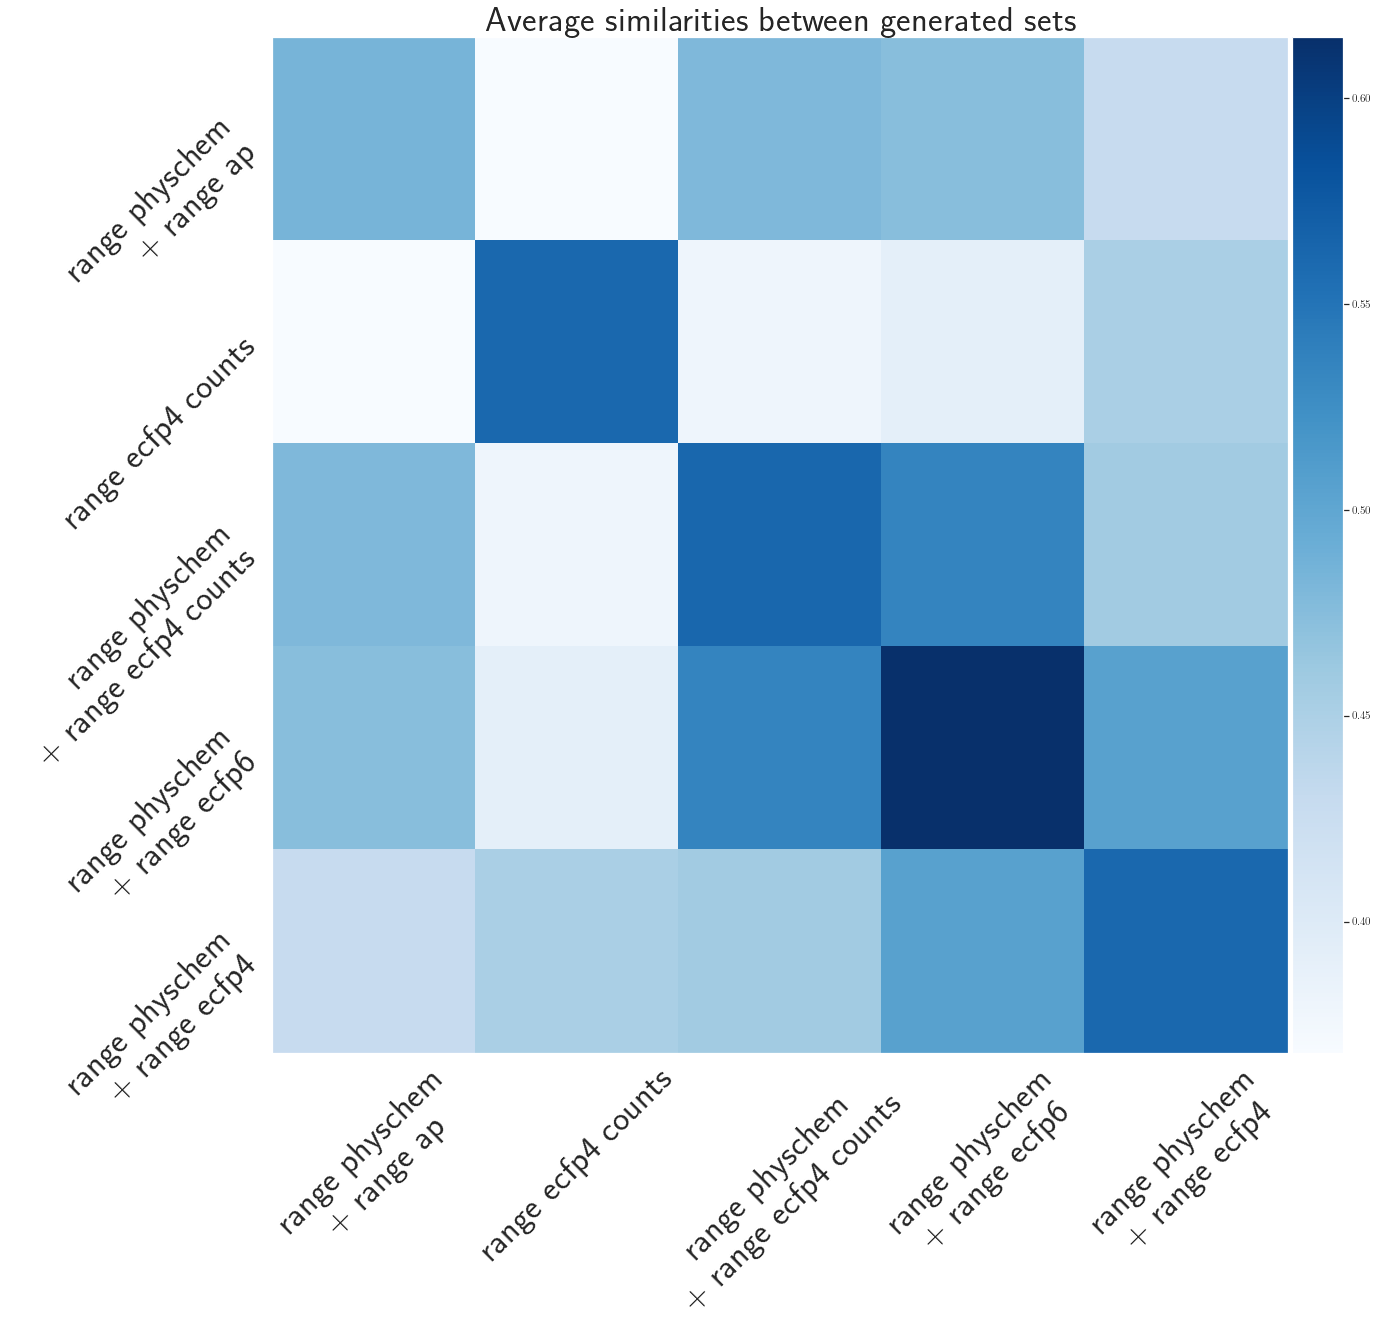

In [183]:
# Displays average generated set - generated set similarities 
from mpl_toolkits.axes_grid1 import make_axes_locatable

labels = ['range physchem + range ap', 'range ecfp4 counts', 'range physchem + range ecfp4 counts', 'range physchem + range ecfp6', 'range physchem + range ecfp4']
labels_xaxis = ['range physchem \n + range ap', 'range ecfp4 counts', 'range physchem \n + range ecfp4 counts', 'range physchem \n + range ecfp6', 'range physchem \n + range ecfp4']


fig, ax = plt.subplots(figsize = (20, 20), nrows=1 , ncols=1)

fig.tight_layout(pad=1.5)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)



ax.set_title("Average similarities between generated sets", fontsize=35)

im = ax.imshow(np.array(average_similarities), cmap='Blues')
ax.set_yticks(ticks=range(len(best_methods)))
ax.set_xticks(ticks=range(len(best_methods)))
ax.set_xticklabels(labels_xaxis, rotation=45)
ax.set_yticklabels(labels_xaxis, rotation=45)
ax.tick_params(axis='both', which='major', labelsize=35)
ax.tick_params(axis='both', which='minor', labelsize=35)
#plt.colorbar()
fig.tight_layout(pad=3.0)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.grid(False)

plt.tight_layout()
plt.savefig('images/JAK2/similarities.pdf', dpi=300)

In [ ]:
# Inspection visuelle des molécules 